# Ride Duration in NYC taxi data

This is a notebook is to predict ride duration from NYC taxi data for MLOps bootcamp week 1.
Data can be found here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

## Importing Packages

In [1]:
import mlflow
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
mlflow.set_tracking_uri("sqlite:///mflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/06/23 19:40:26 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops_zoomcamp/week_02/mlruns/1', creation_time=1719171626428, experiment_id='1', last_update_time=1719171626428, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## Seeting up training and evalutation

In [3]:
df_train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')


df_train['duration'] = df_train.lpep_dropoff_datetime - df_train.lpep_pickup_datetime
df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

df_val['duration'] = df_val.lpep_dropoff_datetime - df_val.lpep_pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]


categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

In [4]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.1228220948023795

In [6]:
y_pred_val = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred_val)

7.265831283470444

## Visualization of the predictions vs actual 

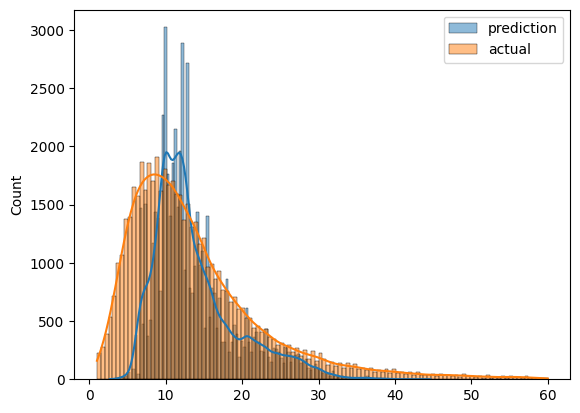

In [20]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)

plt.legend()
plt.show()

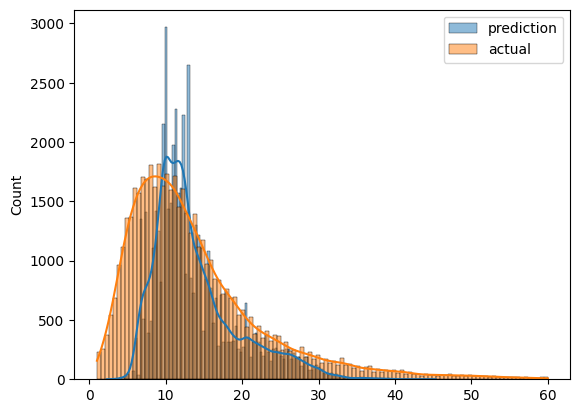

In [21]:
sns.histplot(y_pred_val, label='prediction', kde=True)
sns.histplot(y_val, label='actual', kde=True)

plt.legend()
plt.show()

## Exporting using pickle

In [7]:
with open('model_lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Example using mlflow run

From the first video with the demo

In [11]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "isabella")

    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("val-data-path", "'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)


## Experiment tracking (going deeper)

In [12]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [17]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [18]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:7.98299                                                               
  0%|                                              | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:30:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.14878                                                               
[2]	validation-rmse:6.54512                                                               
[3]	validation-rmse:6.11320                                                               
[4]	validation-rmse:5.81131                                                               
[5]	validation-rmse:5.60065                                                               
[6]	validation-rmse:5.45397                                                               
[7]	validation-rmse:5.35277                                                               
[8]	validation-rmse:5.28569                                                               
[9]	validation-rmse:5.23767                                                               
[10]	validation-rmse:5.20770                                                              
[11]	validation-rmse:5.18406                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:31:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.99731                                                               
[1]	validation-rmse:6.05559                                                               
[2]	validation-rmse:5.68063                                                               
[3]	validation-rmse:5.54076                                                               
[4]	validation-rmse:5.50231                                                               
[5]	validation-rmse:5.50047                                                               
[6]	validation-rmse:5.50513                                                               
[7]	validation-rmse:5.51993                                                               
[8]	validation-rmse:5.52778                                                               
[9]	validation-rmse:5.53441                                                               
[10]	validation-rmse:5.54180                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:31:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.21550                                                               
[4]	validation-rmse:6.89691                                                               
[5]	validation-rmse:6.62658                                                               
[6]	validation-rmse:6.39633                                                               
[7]	validation-rmse:6.20548                                                               
[8]	validation-rmse:6.04486                                                               
[9]	validation-rmse:5.91160                                                               
[10]	validation-rmse:5.79901                                                              
[11]	validation-rmse:5.70125                                                              
[12]	validation-rmse:5.62300                                                              
[13]	validation-rmse:5.55646                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:31:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.12400                                                               
[1]	validation-rmse:6.17448                                                               
[2]	validation-rmse:5.76869                                                               
[3]	validation-rmse:5.60971                                                               
[4]	validation-rmse:5.55267                                                               
[5]	validation-rmse:5.54850                                                               
[6]	validation-rmse:5.55465                                                               
[7]	validation-rmse:5.55640                                                               
[8]	validation-rmse:5.56561                                                               
[9]	validation-rmse:5.58000                                                               
[10]	validation-rmse:5.58804                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:31:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04467                                                               
[1]	validation-rmse:7.24236                                                               
[2]	validation-rmse:6.65345                                                               
[3]	validation-rmse:6.21863                                                               
[4]	validation-rmse:5.91416                                                               
[5]	validation-rmse:5.70045                                                               
[6]	validation-rmse:5.55113                                                               
[7]	validation-rmse:5.45053                                                               
[8]	validation-rmse:5.37739                                                               
[9]	validation-rmse:5.33194                                                               
[10]	validation-rmse:5.30076                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:31:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.57702                                                               
[3]	validation-rmse:7.19762                                                               
[4]	validation-rmse:6.87396                                                               
[5]	validation-rmse:6.59532                                                               
[6]	validation-rmse:6.35939                                                               
[7]	validation-rmse:6.15968                                                               
[8]	validation-rmse:5.98942                                                               
[9]	validation-rmse:5.84842                                                               
[10]	validation-rmse:5.72903                                                              
[11]	validation-rmse:5.63000                                                              
[12]	validation-rmse:5.54631                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:32:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.32849                                                               
[2]	validation-rmse:5.21247                                                               
[3]	validation-rmse:5.18933                                                               
[4]	validation-rmse:5.17502                                                               
[5]	validation-rmse:5.16570                                                               
[6]	validation-rmse:5.16864                                                               
[7]	validation-rmse:5.17089                                                               
[8]	validation-rmse:5.16653                                                               
[9]	validation-rmse:5.17081                                                               
[10]	validation-rmse:5.17397                                                              
[11]	validation-rmse:5.17250                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:32:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72902                                                               
[1]	validation-rmse:8.37954                                                               
[2]	validation-rmse:8.05959                                                               
[3]	validation-rmse:7.76928                                                               
[4]	validation-rmse:7.50551                                                               
[5]	validation-rmse:7.26615                                                               
[6]	validation-rmse:7.05061                                                               
[7]	validation-rmse:6.85546                                                               
[8]	validation-rmse:6.67827                                                               
[9]	validation-rmse:6.51969                                                               
[10]	validation-rmse:6.37835                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:32:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.95857
[3]	validation-rmse:7.64763                                                               
[4]	validation-rmse:7.36985                                                               
[5]	validation-rmse:7.11840                                                               
[6]	validation-rmse:6.89461                                                               
[7]	validation-rmse:6.69287                                                               
[8]	validation-rmse:6.51371                                                               
[9]	validation-rmse:6.35441                                                               
[10]	validation-rmse:6.21211                                                              
[11]	validation-rmse:6.08740                                                              
[12]	validation-rmse:5.97771                                                              
[13]	validation-rmse:5.87965                                  

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:32:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68951                                                               
[1]	validation-rmse:8.30796                                                               
[2]	validation-rmse:7.96214                                                               
[3]	validation-rmse:7.65419                                                               
[4]	validation-rmse:7.37422                                                               
[5]	validation-rmse:7.12525                                                               
[6]	validation-rmse:6.90203                                                               
[7]	validation-rmse:6.70350                                                               
[8]	validation-rmse:6.52654                                                               
[9]	validation-rmse:6.37134                                                               
[10]	validation-rmse:6.23289                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.54631                                                               
[1]	validation-rmse:5.66396                                                               
[2]	validation-rmse:5.38247                                                               
[3]	validation-rmse:5.32199                                                               
[4]	validation-rmse:5.32102                                                               
[5]	validation-rmse:5.33674                                                               
[6]	validation-rmse:5.34713                                                               
[7]	validation-rmse:5.35355                                                               
[8]	validation-rmse:5.35423                                                               
[9]	validation-rmse:5.35560                                                               
[10]	validation-rmse:5.35914                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.53673                                                               
[1]	validation-rmse:6.55228                                                               
[2]	validation-rmse:5.96030                                                               
[3]	validation-rmse:5.60569                                                               
[4]	validation-rmse:5.41236                                                               
[5]	validation-rmse:5.30676                                                               
[6]	validation-rmse:5.24952                                                               
[7]	validation-rmse:5.21956                                                               
[8]	validation-rmse:5.20271                                                               
[9]	validation-rmse:5.19279                                                               
[10]	validation-rmse:5.19088                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.66903                                                               
[1]	validation-rmse:6.72773                                                               
[2]	validation-rmse:6.12511                                                               
[3]	validation-rmse:5.76415                                                               
[4]	validation-rmse:5.57405                                                               
[5]	validation-rmse:5.47724                                                               
[6]	validation-rmse:5.42195                                                               
[7]	validation-rmse:5.40117                                                               
[8]	validation-rmse:5.40128                                                               
[9]	validation-rmse:5.40478                                                               
[10]	validation-rmse:5.41953                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.60310                                                               
[1]	validation-rmse:5.68957                                                               
[2]	validation-rmse:5.75786                                                               
[3]	validation-rmse:5.76635                                                               
[4]	validation-rmse:5.77584                                                               
[5]	validation-rmse:5.79575                                                               
[6]	validation-rmse:5.79957                                                               
[7]	validation-rmse:5.81383                                                               
[8]	validation-rmse:5.81880                                                               
[9]	validation-rmse:5.82196                                                               
[10]	validation-rmse:5.82531                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03831
[1]	validation-rmse:7.23151                                                               
[2]	validation-rmse:6.63948                                                               
[3]	validation-rmse:6.20278                                                               
[4]	validation-rmse:5.89135                                                               
[5]	validation-rmse:5.67434                                                               
[6]	validation-rmse:5.51553                                                               
[7]	validation-rmse:5.40954                                                               
[8]	validation-rmse:5.33790                                                               
[9]	validation-rmse:5.28291                                                               
[10]	validation-rmse:5.24538                                                              
[11]	validation-rmse:5.21989                                  

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.01903                                                               
[1]	validation-rmse:5.52288                                                               
[2]	validation-rmse:5.50682                                                               
[3]	validation-rmse:5.53872                                                               
[4]	validation-rmse:5.56429                                                               
[5]	validation-rmse:5.58410                                                               
[6]	validation-rmse:5.59710                                                               
[7]	validation-rmse:5.60059                                                               
[8]	validation-rmse:5.60815                                                               
[9]	validation-rmse:5.61552                                                               
[10]	validation-rmse:5.62252                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:34:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.58626                                                               
[1]	validation-rmse:8.12594                                                               
[2]	validation-rmse:7.72527                                                               
[3]	validation-rmse:7.37238                                                               
[4]	validation-rmse:7.06571                                                               
[5]	validation-rmse:6.80297                                                               
[6]	validation-rmse:6.58036                                                               
[7]	validation-rmse:6.38652                                                               
[8]	validation-rmse:6.22033                                                               
[9]	validation-rmse:6.08239                                                               
[10]	validation-rmse:5.96720                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:34:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.35990                                                               
[1]	validation-rmse:7.73711                                                               
[2]	validation-rmse:7.22043                                                               
[3]	validation-rmse:6.79912                                                               
[4]	validation-rmse:6.45769                                                               
[5]	validation-rmse:6.18121                                                               
[6]	validation-rmse:5.96254                                                               
[7]	validation-rmse:5.78628                                                               
[8]	validation-rmse:5.64810                                                               
[9]	validation-rmse:5.54184                                                               
[10]	validation-rmse:5.45667                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:34:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76631                                                               
[1]	validation-rmse:8.44860                                                               
[2]	validation-rmse:8.15323                                                               
[3]	validation-rmse:7.88475                                                               
[4]	validation-rmse:7.63720                                                               
[5]	validation-rmse:7.40901                                                               
[6]	validation-rmse:7.20212                                                               
[7]	validation-rmse:7.01432                                                               
[8]	validation-rmse:6.84179                                                               
[9]	validation-rmse:6.68515                                                               
[10]	validation-rmse:6.54488                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:35:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.35746                                                               
[4]	validation-rmse:6.03025                                                               
[5]	validation-rmse:5.79142                                                               
[6]	validation-rmse:5.61454                                                               
[7]	validation-rmse:5.48738                                                               
[8]	validation-rmse:5.39239                                                               
[9]	validation-rmse:5.32718                                                               
[10]	validation-rmse:5.27839                                                              
[11]	validation-rmse:5.23859                                                              
[12]	validation-rmse:5.21016                                                              
[13]	validation-rmse:5.18833                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:35:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:5.78237                                                               
[9]	validation-rmse:5.67482                                                               
[10]	validation-rmse:5.59045                                                              
[11]	validation-rmse:5.52494                                                              
[12]	validation-rmse:5.47086                                                              
[13]	validation-rmse:5.42408                                                              
[14]	validation-rmse:5.38744                                                              
[15]	validation-rmse:5.35741                                                              
[16]	validation-rmse:5.33521                                                              
[17]	validation-rmse:5.31201                                                              
[18]	validation-rmse:5.29606                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:35:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:5.54771                                                              
[13]	validation-rmse:5.50412                                                              
[14]	validation-rmse:5.47360                                                              
[15]	validation-rmse:5.44541                                                              
[16]	validation-rmse:5.42345                                                              
[17]	validation-rmse:5.40647                                                              
[18]	validation-rmse:5.39016                                                              
[19]	validation-rmse:5.37570                                                              
[20]	validation-rmse:5.36602                                                              
[21]	validation-rmse:5.35676                                                              
[22]	validation-rmse:5.34994                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:35:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:5.69854                                                              
[11]	validation-rmse:5.63318                                                              
[12]	validation-rmse:5.57524                                                              
[13]	validation-rmse:5.53128                                                              
[14]	validation-rmse:5.49473                                                              
[15]	validation-rmse:5.46226                                                              
[16]	validation-rmse:5.43863                                                              
[17]	validation-rmse:5.41893                                                              
[18]	validation-rmse:5.40180                                                              
[19]	validation-rmse:5.38833                                                              
[20]	validation-rmse:5.37347                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:36:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:5.65481                                                              
[11]	validation-rmse:5.58440                                                              
[12]	validation-rmse:5.53333                                                              
[13]	validation-rmse:5.49004                                                              
[14]	validation-rmse:5.45422                                                              
[15]	validation-rmse:5.42522                                                              
[16]	validation-rmse:5.39917                                                              
[17]	validation-rmse:5.38113                                                              
[18]	validation-rmse:5.36164                                                              
[19]	validation-rmse:5.34571                                                              
[20]	validation-rmse:5.33320                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:36:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:5.40166                                                              
[15]	validation-rmse:5.39831                                                              
[16]	validation-rmse:5.39647                                                              
[17]	validation-rmse:5.39032                                                              
[18]	validation-rmse:5.38563                                                              
[19]	validation-rmse:5.38191                                                              
[20]	validation-rmse:5.37673                                                              
[21]	validation-rmse:5.37310                                                              
[22]	validation-rmse:5.36787                                                              
[23]	validation-rmse:5.36275                                                              
[24]	validation-rmse:5.35959                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:36:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.52410                                                               
[2]	validation-rmse:8.26177                                                               
[3]	validation-rmse:8.01748                                                               
[4]	validation-rmse:7.79231                                                               
[5]	validation-rmse:7.58265                                                               
[6]	validation-rmse:7.38870                                                               
[7]	validation-rmse:7.20897                                                               
[8]	validation-rmse:7.04126                                                               
[9]	validation-rmse:6.88896                                                               
[10]	validation-rmse:6.74685                                                              
[11]	validation-rmse:6.61772                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:36:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.30540                                                               
[4]	validation-rmse:6.99042                                                               
[5]	validation-rmse:6.72214                                                               
[6]	validation-rmse:6.48598                                                               
[7]	validation-rmse:6.28495                                                               
[8]	validation-rmse:6.11655                                                               
[9]	validation-rmse:5.97229                                                               
[10]	validation-rmse:5.84900                                                              
[11]	validation-rmse:5.74572                                                              
[12]	validation-rmse:5.65845                                                              
[13]	validation-rmse:5.58104                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:36:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.48967                                                               
[2]	validation-rmse:8.21323                                                               
[3]	validation-rmse:7.95625                                                               
[4]	validation-rmse:7.71903                                                               
[5]	validation-rmse:7.50201                                                               
[6]	validation-rmse:7.29911                                                               
[7]	validation-rmse:7.11477                                                               
[8]	validation-rmse:6.94358                                                               
[9]	validation-rmse:6.78425                                                               
[10]	validation-rmse:6.64047                                                              
[11]	validation-rmse:6.50784                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:37:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.79768                                                               
[7]	validation-rmse:6.59838                                                               
[8]	validation-rmse:6.42460                                                               
[9]	validation-rmse:6.27343                                                               
[10]	validation-rmse:6.13925                                                              
[11]	validation-rmse:6.02283                                                              
[12]	validation-rmse:5.91954                                                              
[13]	validation-rmse:5.83069                                                              
[14]	validation-rmse:5.74980                                                              
[15]	validation-rmse:5.68086                                                              
[16]	validation-rmse:5.62077                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:37:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.81423                                                               
[1]	validation-rmse:6.91393                                                               
[2]	validation-rmse:6.29830                                                               
[3]	validation-rmse:5.88754                                                               
[4]	validation-rmse:5.63059                                                               
[5]	validation-rmse:5.46075                                                               
[6]	validation-rmse:5.35806                                                               
[7]	validation-rmse:5.29527                                                               
[8]	validation-rmse:5.25859                                                               
[9]	validation-rmse:5.23655                                                               
[10]	validation-rmse:5.22124                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:37:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.49509                                                               
[4]	validation-rmse:7.19790                                                               
[5]	validation-rmse:6.93635                                                               
[6]	validation-rmse:6.70493                                                               
[7]	validation-rmse:6.50190                                                               
[8]	validation-rmse:6.32426                                                               
[9]	validation-rmse:6.17049                                                               
[10]	validation-rmse:6.03665                                                              
[11]	validation-rmse:5.91952                                                              
[12]	validation-rmse:5.81797                                                              
[13]	validation-rmse:5.72933                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:37:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.47567                                                               
[2]	validation-rmse:6.91036                                                               
[3]	validation-rmse:6.47085                                                               
[4]	validation-rmse:6.13422                                                               
[5]	validation-rmse:5.88109                                                               
[6]	validation-rmse:5.68912                                                               
[7]	validation-rmse:5.54675                                                               
[8]	validation-rmse:5.43800                                                               
[9]	validation-rmse:5.36234                                                               
[10]	validation-rmse:5.30659                                                              
[11]	validation-rmse:5.26488                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:37:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.75856                                                               
[5]	validation-rmse:6.48988                                                               
[6]	validation-rmse:6.26540                                                               
[7]	validation-rmse:6.07796                                                               
[8]	validation-rmse:5.92560                                                               
[9]	validation-rmse:5.79264                                                               
[10]	validation-rmse:5.68758                                                              
[11]	validation-rmse:5.60060                                                              
[12]	validation-rmse:5.52928                                                              
[13]	validation-rmse:5.47147                                                              
[14]	validation-rmse:5.41788                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:38:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.15458                                                               
[2]	validation-rmse:5.63536                                                               
[3]	validation-rmse:5.38499                                                               
[4]	validation-rmse:5.27021                                                               
[5]	validation-rmse:5.20045                                                               
[6]	validation-rmse:5.16600                                                               
[7]	validation-rmse:5.14780                                                               
[8]	validation-rmse:5.14028                                                               
[9]	validation-rmse:5.13383                                                               
[10]	validation-rmse:5.12659                                                              
[11]	validation-rmse:5.11955                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:38:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[15]	validation-rmse:5.52072                                                              
[16]	validation-rmse:5.50364                                                              
[17]	validation-rmse:5.48710                                                              
[18]	validation-rmse:5.47346                                                              
[19]	validation-rmse:5.46497                                                              
[20]	validation-rmse:5.45641                                                              
[21]	validation-rmse:5.44821                                                              
[22]	validation-rmse:5.44038                                                              
[23]	validation-rmse:5.43498                                                              
[24]	validation-rmse:5.42862                                                              
[25]	validation-rmse:5.42195                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:38:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.80098                                                               
[5]	validation-rmse:5.61533                                                               
[6]	validation-rmse:5.48695                                                               
[7]	validation-rmse:5.39926                                                               
[8]	validation-rmse:5.33920                                                               
[9]	validation-rmse:5.29857                                                               
[10]	validation-rmse:5.26923                                                              
[11]	validation-rmse:5.24561                                                              
[12]	validation-rmse:5.22769                                                              
[13]	validation-rmse:5.21353                                                              
[14]	validation-rmse:5.20264                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:38:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.94475                                                               
[2]	validation-rmse:7.48327                                                               
[3]	validation-rmse:7.09093                                                               
[4]	validation-rmse:6.76026                                                               
[5]	validation-rmse:6.48120                                                               
[6]	validation-rmse:6.24804                                                               
[7]	validation-rmse:6.05253                                                               
[8]	validation-rmse:5.88846                                                               
[9]	validation-rmse:5.75463                                                               
[10]	validation-rmse:5.64311                                                              
[11]	validation-rmse:5.55029                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:38:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70384                                                               
[1]	validation-rmse:8.33401                                                               
[2]	validation-rmse:7.99841                                                               
[3]	validation-rmse:7.69515                                                               
[4]	validation-rmse:7.42072                                                               
[5]	validation-rmse:7.17530                                                               
[6]	validation-rmse:6.95153                                                               
[7]	validation-rmse:6.75439                                                               
[8]	validation-rmse:6.57321                                                               
[9]	validation-rmse:6.41510                                                               
[10]	validation-rmse:6.27392                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:38:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63755                                                               
[1]	validation-rmse:8.21620                                                               
[2]	validation-rmse:7.83899                                                               
[3]	validation-rmse:7.50464                                                               
[4]	validation-rmse:7.20832                                                               
[5]	validation-rmse:6.94875                                                               
[6]	validation-rmse:6.71928                                                               
[7]	validation-rmse:6.51828                                                               
[8]	validation-rmse:6.34303                                                               
[9]	validation-rmse:6.19131                                                               
[10]	validation-rmse:6.06294                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:39:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.66194                                                               
[3]	validation-rmse:7.30161                                                               
[4]	validation-rmse:6.99037                                                               
[5]	validation-rmse:6.72450                                                               
[6]	validation-rmse:6.49139                                                               
[7]	validation-rmse:6.29595                                                               
[8]	validation-rmse:6.12634                                                               
[9]	validation-rmse:5.98563                                                               
[10]	validation-rmse:5.86512                                                              
[11]	validation-rmse:5.76042                                                              
[12]	validation-rmse:5.67344                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:39:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.45040                                                               
[1]	validation-rmse:7.88838                                                               
[2]	validation-rmse:7.41388                                                               
[3]	validation-rmse:7.01543                                                               
[4]	validation-rmse:6.67787                                                               
[5]	validation-rmse:6.39845                                                               
[6]	validation-rmse:6.16840                                                               
[7]	validation-rmse:5.97752                                                               
[8]	validation-rmse:5.82218                                                               
[9]	validation-rmse:5.69559                                                               
[10]	validation-rmse:5.59254                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:39:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.31489                                                               
[4]	validation-rmse:5.24271                                                               
[5]	validation-rmse:5.20389                                                               
[6]	validation-rmse:5.17418                                                               
[7]	validation-rmse:5.15924                                                               
[8]	validation-rmse:5.14635                                                               
[9]	validation-rmse:5.14065                                                               
[10]	validation-rmse:5.13301                                                              
[11]	validation-rmse:5.13134                                                              
[12]	validation-rmse:5.12945                                                              
[13]	validation-rmse:5.13183                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:39:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.64544                                                               
[6]	validation-rmse:5.50055                                                               
[7]	validation-rmse:5.40214                                                               
[8]	validation-rmse:5.33176                                                               
[9]	validation-rmse:5.28304                                                               
[10]	validation-rmse:5.24627                                                              
[11]	validation-rmse:5.21912                                                              
[12]	validation-rmse:5.19694                                                              
[13]	validation-rmse:5.18347                                                              
[14]	validation-rmse:5.17223                                                              
[15]	validation-rmse:5.16251                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.39335                                                               
[2]	validation-rmse:8.07975                                                               
[3]	validation-rmse:7.79194                                                               
[4]	validation-rmse:7.52969                                                               
[5]	validation-rmse:7.29012                                                               
[6]	validation-rmse:7.07308                                                               
[7]	validation-rmse:6.87601                                                               
[8]	validation-rmse:6.69762                                                               
[9]	validation-rmse:6.53525                                                               
[10]	validation-rmse:6.38833                                                              
[11]	validation-rmse:6.25620                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.75004                                                               
[2]	validation-rmse:6.13598                                                               
[3]	validation-rmse:5.75100                                                               
[4]	validation-rmse:5.51614                                                               
[5]	validation-rmse:5.37016                                                               
[6]	validation-rmse:5.28708                                                               
[7]	validation-rmse:5.23910                                                               
[8]	validation-rmse:5.21138                                                               
[9]	validation-rmse:5.19244                                                               
[10]	validation-rmse:5.18131                                                              
[11]	validation-rmse:5.17370                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.38062                                                               
[2]	validation-rmse:5.22916                                                               
[3]	validation-rmse:5.19137                                                               
[4]	validation-rmse:5.17816                                                               
[5]	validation-rmse:5.17246                                                               
[6]	validation-rmse:5.17267                                                               
[7]	validation-rmse:5.16886                                                               
[8]	validation-rmse:5.15802                                                               
[9]	validation-rmse:5.15799                                                               
[10]	validation-rmse:5.15644                                                              
[11]	validation-rmse:5.16118                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.73997                                                               
[3]	validation-rmse:7.38667                                                               
[4]	validation-rmse:7.07734                                                               
[5]	validation-rmse:6.80683                                                               
[6]	validation-rmse:6.57068                                                               
[7]	validation-rmse:6.36614                                                               
[8]	validation-rmse:6.18953                                                               
[9]	validation-rmse:6.03767                                                               
[10]	validation-rmse:5.90874                                                              
[11]	validation-rmse:5.79522                                                              
[12]	validation-rmse:5.69941                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.47467                                                               
[1]	validation-rmse:5.36552                                                               
[2]	validation-rmse:5.39024                                                               
[3]	validation-rmse:5.41083                                                               
[4]	validation-rmse:5.42854                                                               
[5]	validation-rmse:5.43685                                                               
[6]	validation-rmse:5.45654                                                               
[7]	validation-rmse:5.46076                                                               
[8]	validation-rmse:5.46659                                                               
[9]	validation-rmse:5.47575                                                               
[10]	validation-rmse:5.46726                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.31482                                                               
[1]	validation-rmse:6.28654                                                               
[2]	validation-rmse:5.74956                                                               
[3]	validation-rmse:5.47011                                                               
[4]	validation-rmse:5.33704                                                               
[5]	validation-rmse:5.27827                                                               
[6]	validation-rmse:5.25513                                                               
[7]	validation-rmse:5.24891                                                               
[8]	validation-rmse:5.24886                                                               
[9]	validation-rmse:5.25244                                                               
[10]	validation-rmse:5.24836                                                              

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:40:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:5.47654                                                               
[10]	validation-rmse:5.42029                                                              
[11]	validation-rmse:5.37938                                                              
[12]	validation-rmse:5.34359                                                              
[13]	validation-rmse:5.31859                                                              
[14]	validation-rmse:5.29717                                                              
[15]	validation-rmse:5.28104                                                              
[16]	validation-rmse:5.26581                                                              
[17]	validation-rmse:5.25332                                                              
[18]	validation-rmse:5.24429                                                              
[19]	validation-rmse:5.23490                                                              

You can use autolog with mlflow with certain libraries that are compatible

In [ ]:
mlflow.xgboost.autolog()

best_params = {
        'learning_rate': 0.90632889574099,
        'max_depth': 81,
        'min_child_weight': 0.4987414920461141,
        'objective': 'reg:linear',
        'reg_alpha': 0.007363025955087392,
        'reg_lambda': 0.24569246315166615,
        'seed': 42
}

booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
)

Using mlflow the more traditional way

In [19]:
mlflow.xgboost.autolog(disable=True)


In [22]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.90632889574099,
        'max_depth': 81,
        'min_child_weight': 0.4987414920461141,
        'objective': 'reg:linear',
        'reg_alpha': 0.007363025955087392,
        'reg_lambda': 0.24569246315166615,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:5.60310
[1]	validation-rmse:5.68957
[2]	validation-rmse:5.75786
[3]	validation-rmse:5.76635
[4]	validation-rmse:5.77584
[5]	validation-rmse:5.79575
[6]	validation-rmse:5.79957
[7]	validation-rmse:5.81383
[8]	validation-rmse:5.81880
[9]	validation-rmse:5.82196
[10]	validation-rmse:5.82531
[11]	validation-rmse:5.83311
[12]	validation-rmse:5.83540
[13]	validation-rmse:5.83687
[14]	validation-rmse:5.83792
[15]	validation-rmse:5.83806
[16]	validation-rmse:5.83830
[17]	validation-rmse:5.83865
[18]	validation-rmse:5.83901
[19]	validation-rmse:5.83938
[20]	validation-rmse:5.83953
[21]	validation-rmse:5.83968
[22]	validation-rmse:5.83980
[23]	validation-rmse:5.83985
[24]	validation-rmse:5.83989
[25]	validation-rmse:5.83992
[26]	validation-rmse:5.83992
[27]	validation-rmse:5.83994
[28]	validation-rmse:5.83994
[29]	validation-rmse:5.83995
[30]	validation-rmse:5.83995
[31]	validation-rmse:5.83995
[32]	validation-rmse:5.83995
[33]	validation-rmse:5.83995
[34]	validation-rmse:5.8

2024/06/23 20:58:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## Model management and saving the models

Option one: saving the model as an artifact

In [24]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "isabella")

    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("val-data-path", "'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

2024/06/23 21:11:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


it could be nicer to save it a way that anybody could run it easily!

In [26]:
mlflow.xgboost.autolog(disable=True)


In [29]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.90632889574099,
        'max_depth': 81,
        'min_child_weight': 0.4987414920461141,
        'objective': 'reg:linear',
        'reg_alpha': 0.007363025955087392,
        'reg_lambda': 0.24569246315166615,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:5.60310
[1]	validation-rmse:5.68957
[2]	validation-rmse:5.75786
[3]	validation-rmse:5.76635
[4]	validation-rmse:5.77584
[5]	validation-rmse:5.79575
[6]	validation-rmse:5.79957
[7]	validation-rmse:5.81383
[8]	validation-rmse:5.81880
[9]	validation-rmse:5.82196
[10]	validation-rmse:5.82531
[11]	validation-rmse:5.83311
[12]	validation-rmse:5.83540
[13]	validation-rmse:5.83687
[14]	validation-rmse:5.83792
[15]	validation-rmse:5.83806
[16]	validation-rmse:5.83830
[17]	validation-rmse:5.83865
[18]	validation-rmse:5.83901
[19]	validation-rmse:5.83938
[20]	validation-rmse:5.83953
[21]	validation-rmse:5.83968
[22]	validation-rmse:5.83980
[23]	validation-rmse:5.83985
[24]	validation-rmse:5.83989
[25]	validation-rmse:5.83992
[26]	validation-rmse:5.83992
[27]	validation-rmse:5.83994
[28]	validation-rmse:5.83994
[29]	validation-rmse:5.83995
[30]	validation-rmse:5.83995
[31]	validation-rmse:5.83995
[32]	validation-rmse:5.83995
[33]	validation-rmse:5.83995
[34]	validation-rmse:5.8

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:21:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Bad pipe message: %s [b'"Not/A)Brand";v="8", "Chromium";v="126", "Google Chrome";']
Bad pipe message: %s [b'"126"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua-platform: "Linux"\r\nDNT: 1\r\nUpgrade-Insecure-Requests: 1\r\nUser-Agent: Mozilla/5', b' (X11; Linux x86_64) AppleWebKit/537.36 (KHTM']
Bad pipe message: %s [b' like Gecko) Chrome/126.0.0.0 Safari/537.36\r\nAccept: text/html,application/']
Bad pipe message: %s [b'tml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nSec-Fe']
Bad pipe message: %s [b'h-Site: none\r\nSec-Fetch-Mode: navigate\r\nSec-Fetch-User: ?1\r\nSec-Fetch-Dest: document\r\nAccept-Encoding: gzip, deflat', b' br, zstd\r\nAccept-Language: pt-BR,pt;q=0.9,es-MX;q=0.8,es;q=0.7,fr-FR;q=0.6,fr;q=0.5,en-US;q=0.4,en;']
Bad pipe message: %s [b'0.3,gl;q=0.2\r\nCookie: username-127-0-0-1-8888="2|1:0|10:1718472472|23:username-127-0-0-1-8888|204:eyJ1c2VybmFtZS', b'ICI3MDY3MjU4OGU3OWI0NzFlODg5NmJmNDQwNjg2YjM4NiIsICJuYW1lIjog